In [280]:
import h5py
import tensorflow as tf
import cv2
import csv
import numpy as np
import io
import time
import json
import base64
from PIL import Image
from matplotlib import pyplot as plt
from google.protobuf.json_format import MessageToJson
from collections import defaultdict

In [281]:
from interpretation_util import *

In [282]:
%autoreload
# Utils from models/research/object_detection/
from utils import label_map_util
from utils import visualization_utils as vis_util
from utils import ops as utils_ops

UsageError: Line magic function `%autoreload` not found.


In [315]:
from importlib import reload
reload(label_map_util)
reload(vis_util)
reload(utils_ops)

C:\Users\Landscape\Anaconda3\envs\PythonDLCPU\lib\site-packages\matplotlib\__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'utils.ops' from 'D:\\User_Files\\HKU\\Gardnerella\\BacteriaRecognition\\recognition\\models\\faster_rcnn_resnet50_coco_2018_01_28\\utils\\ops.py'>

In [294]:
class Dataset(object):
    def __init__(self, ground_truth_file_path, prediction_file_path, original_file_path, interpretation_file_path):
        
        self.interpretations = defaultdict(dict)
        with open(interpretation_file_path, 'r') as csvinfile:
            db_reader = csv.reader(csvinfile, delimiter=',', quotechar="'")
            begin = True
            for row in db_reader:
                if begin:
                    begin = False
                    continue
                file_name = row[0] if row[0].endswith(".JPG") else row[0] + ".JPG"
                self.interpretations[file_name] = {'scores': [int(row[4]), int(row[1]), int(row[2]), int(row[3])], 
                                                'interpretation': row[5]}
        
        self.originals = defaultdict(dict)
        index = 0
        for string_record in tf.python_io.tf_record_iterator(original_file_path):
            example = tf.train.Example()
            example.ParseFromString(string_record)
            this_file_dict = {}
            
            this_file_dict['id'] = index
            this_file_dict['filename'] = (example.features.feature['image/filename'].bytes_list.value[0].decode("utf-8") )
            this_file_dict['height'] = int(example.features.feature['image/height'].int64_list.value[0])
            this_file_dict['width'] = int(example.features.feature['image/width'].int64_list.value[0])
            this_file_dict['encoded_jpg'] = (example.features.feature['image/encoded'].bytes_list.value[0])
            this_file_dict['xmin'] = np.array(example.features.feature['image/object/bbox/xmin'].float_list.value, dtype=float)
            this_file_dict['xmax'] = np.array(example.features.feature['image/object/bbox/xmax'].float_list.value, dtype=float)
            this_file_dict['ymin'] = np.array(example.features.feature['image/object/bbox/ymin'].float_list.value, dtype=float)
            this_file_dict['ymax'] = np.array(example.features.feature['image/object/bbox/ymax'].float_list.value, dtype=float)
            this_file_dict['bbox'] = np.array([list(box) for box in zip(this_file_dict['ymin'], this_file_dict['xmin'], this_file_dict['ymax'], this_file_dict['xmax'])], dtype=float)
            this_file_dict['class_text'] = [text.decode("utf-8") for text in example.features.feature['image/object/class/text'].bytes_list.value]
            this_file_dict['class_label'] = np.array(list(example.features.feature['image/object/class/label'].int64_list.value), dtype=np.uint8)
            this_file_dict['label_num'] = len(this_file_dict['class_label'])
            this_file_dict['scores'] = np.full(this_file_dict['label_num'], 1.0)
            this_file_dict['source_file'] = ground_truth_file_path

            self.originals[this_file_dict['filename']] = this_file_dict
            index += 1
        
        self.truths = defaultdict(dict)
        index = 0
        for string_record in tf.python_io.tf_record_iterator(ground_truth_file_path):
            example = tf.train.Example()
            example.ParseFromString(string_record)
            this_file_dict = {}
            
            this_file_dict['id'] = index
            this_file_dict['filename'] = (example.features.feature['image/filename'].bytes_list.value[0].decode("utf-8") )
            this_file_dict['height'] = int(example.features.feature['image/height'].int64_list.value[0])
            this_file_dict['width'] = int(example.features.feature['image/width'].int64_list.value[0])
            this_file_dict['encoded_jpg'] = (example.features.feature['image/encoded'].bytes_list.value[0])
            this_file_dict['xmin'] = np.array(example.features.feature['image/object/bbox/xmin'].float_list.value, dtype=float)
            this_file_dict['xmax'] = np.array(example.features.feature['image/object/bbox/xmax'].float_list.value, dtype=float)
            this_file_dict['ymin'] = np.array(example.features.feature['image/object/bbox/ymin'].float_list.value, dtype=float)
            this_file_dict['ymax'] = np.array(example.features.feature['image/object/bbox/ymax'].float_list.value, dtype=float)
            this_file_dict['bbox'] = np.array([list(box) for box in zip(this_file_dict['ymin'], this_file_dict['xmin'], this_file_dict['ymax'], this_file_dict['xmax'])], dtype=float)
            this_file_dict['class_text'] = [text.decode("utf-8") for text in example.features.feature['image/object/class/text'].bytes_list.value]
            this_file_dict['class_label'] = np.array(list(example.features.feature['image/object/class/label'].int64_list.value), dtype=np.uint8)
            this_file_dict['label_num'] = len(this_file_dict['class_label'])
            this_file_dict['source_file'] = ground_truth_file_path

            self.truths[this_file_dict['filename']] = this_file_dict
            index += 1
        
        
        self.predictions = defaultdict(dict)
        for string_record in tf.python_io.tf_record_iterator(prediction_file_path):
            example = tf.train.Example()
            example.ParseFromString(string_record)
            this_file_dict = {}

            this_file_dict['id'] = (example.features.feature['batch'].int64_list.value[0])
            this_file_dict['ymin'] = np.array(example.features.feature['ymin'].float_list.value, dtype=float) / 160.0
            this_file_dict['xmin'] = np.array(example.features.feature['xmin'].float_list.value, dtype=float) / 160.0
            this_file_dict['ymax'] = np.array(example.features.feature['ymax'].float_list.value, dtype=float) / 160.0
            this_file_dict['xmax'] = np.array(example.features.feature['xmax'].float_list.value, dtype=float) / 160.0
            this_file_dict['bbox'] = np.array([list(box) for box in zip(this_file_dict['ymin'], this_file_dict['xmin'], this_file_dict['ymax'], this_file_dict['xmax'])], dtype=float)
            this_file_dict['class_label'] = np.array(list(example.features.feature['classes'].int64_list.value), dtype=np.uint8)
            this_file_dict['scores'] = np.array(list(example.features.feature['scores'].float_list.value), dtype=float)
            this_file_dict['label_num'] = len(this_file_dict['class_label'])
            this_file_dict['source_file'] = prediction_file_path

            self.predictions[this_file_dict['id']] = this_file_dict
        

    def get_interpretation_by_file_prefix(self, file_name_prefix):
        return self.interpretations[file_name_prefix + ".JPG"]
        
        
    def get_segment_data_by_file_name(self, filename):
        return (self.truths[filename], self.predictions[self.truths[filename]['id']])
    
    
    def get_all_file_names_with_prefix(self, file_name_prefix):
        return ([key for key in self.originals.keys() if key.startswith(file_name_prefix + '.')],
                       sorted([key for key in self.truths.keys() if key.startswith(file_name_prefix + '_')]))

In [295]:
class Visualizer(object):
    def __init__(self, path_to_labels, num_classes):
        self.label_map = label_map_util.load_labelmap(path_to_labels)
        self.categories = label_map_util.convert_label_map_to_categories(self.label_map, max_num_classes=num_classes, use_display_name=True)
        self.category_index = label_map_util.create_category_index(self.categories)
        
    def get_label_map(self):
        return self.category_index
    
    def draw_visulizations_on_image(self, img_np, boxes, classes, scores, threshold=0.1, fontsize=6, line_thickness=1, alpha=255, max_boxes_to_draw=100):
        img_cp = img_np.copy()
#         img_expanded = np.expand_dims(img_np, axis=0)
        vis_util.visualize_boxes_and_labels_on_image_array(
            img_cp,
            boxes,
            classes,
            scores,
            self.category_index,
            use_normalized_coordinates=True,
            min_score_thresh=threshold,
            line_thickness=line_thickness,
            fontsize=fontsize,
            alpha=alpha,
            max_boxes_to_draw=max_boxes_to_draw)
        return img_cp
    
def draw_comparison_images(img1, img2, title=""):
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12,4))
    ax1.imshow(img1)
    ax1.axis('off')
    ax1.set_title('Predicted')
    ax2.imshow(img2)
    ax2.set_title('Ground Truth')
    ax2.axis('off')
    f.suptitle(title)
    plt.show()
        
def load_image_into_numpy_array(image_path):
    image = Image.open(image_path)
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

In [396]:
vis.category_index

{1: {'id': 1, 'name': 'Lactobacillus'},
 2: {'id': 2, 'name': 'Gardnerella'},
 3: {'id': 3, 'name': 'Curved Rods'},
 4: {'id': 4, 'name': 'Coccus'},
 5: {'id': 5, 'name': 'Yeast'},
 6: {'id': 6, 'name': 'Noise'}}

In [296]:
def combine_all_segments(dataset, file_prefix, scale=(160,160), shape=(8,6), sort_by_score=True):
    # scale in (x,y) format
    original_file, file_list = dataset.get_all_file_names_with_prefix(file_prefix)
    original_file = original_file[0]
    combined_data = {'ymin': np.array([]), 'xmin': np.array([]), 'ymax': np.array([]), 'xmax': np.array([]),
                     'bbox': np.array([[]]), 'class_label': np.array([], dtype=np.uint8), 'scores': np.array([])}
    label_num = 0
    original_img = load_image_into_numpy_array(io.BytesIO(dataset.originals[original_file]['encoded_jpg']))
    def name_index_map(file_name):
        prefix_stripped = file_name[len(file_prefix) + 1:]
        offset_x = int(prefix_stripped[0:4])
        offset_y = int(prefix_stripped[5:9])
        return(offset_x, offset_y)
    
    for file_name in file_list:
        offset_x, offset_y = name_index_map(file_name)
        truth, pred = dataset.get_segment_data_by_file_name(file_name)
        
        combined_data['ymin'] = np.append(combined_data['ymin'], (pred['ymin'] * scale[1] + offset_y) / (scale[1] * shape[1]))
        combined_data['xmin'] = np.append(combined_data['xmin'], (pred['xmin'] * scale[0] + offset_x) / (scale[0] * shape[0]))
        combined_data['ymax'] = np.append(combined_data['ymax'], (pred['ymax'] * scale[1] + offset_y) / (scale[1] * shape[1]))
        combined_data['xmax'] = np.append(combined_data['xmax'], (pred['xmax'] * scale[0] + offset_x) / (scale[0] * shape[0]))
        
        combined_data['class_label'] = np.append(combined_data['class_label'], pred['class_label'])
        combined_data['scores']= np.append(combined_data['scores'], pred['scores'])
        
    if sort_by_score:
        perm = np.argsort(combined_data['scores'])[::-1]
        combined_data['ymin'] = combined_data['ymin'][perm]
        combined_data['xmin'] = combined_data['xmin'][perm]
        combined_data['ymax'] = combined_data['ymax'][perm]
        combined_data['xmax'] = combined_data['xmax'][perm]
        combined_data['class_label'] = combined_data['class_label'][perm]
        combined_data['scores'] = combined_data['scores'][perm]

        combined_data['bbox'] = np.array([list(box) for box in zip(combined_data['ymin'], combined_data['xmin'], combined_data['ymax'], combined_data['xmax'])], dtype=float)
        
    return combined_data, original_img, original_file
    

In [330]:
def visualize_single_image(combined_data, original_img, threshold=0.1, scale=1.0/160.0, fontsize=12, line_thickness=3, alpha=128, max_boxes_to_draw=500, save_to_file=None):   
    fig, ax = plt.subplots(figsize=(original_img.shape[1] * scale, original_img.shape[0] * scale))
#     fig, ax = plt.subplots()
#     img_cp = np.zeros((original_img.shape[0], original_img.shape[1], original_img.shape[2] + 1), dtype=original_img.dtype)
#     img_cp[:,:,:-1] = original_img
    ax.axis('off')
    ax.imshow(vis.draw_visulizations_on_image(original_img, 
                                              combined_data['bbox'], 
                                              combined_data['class_label'], 
                                              combined_data['scores'], 
                                              threshold=threshold, 
                                              fontsize=fontsize, 
                                              line_thickness=line_thickness, 
                                              alpha=alpha,
                                              max_boxes_to_draw=max_boxes_to_draw), aspect='auto')
    if save_to_file is not None:
        plt.savefig(save_to_file, bbox_inches='tight')
    plt.show()

In [298]:
def non_maximum_suppression(combined_data, threshold=0.01, same_class_iou=0.5, diff_class_iou=0.6, iou_mode="min_area"):
    # if there are no boxes, return an empty list
    if len(combined_data['xmin']) == 0:
        return []

    # initialize the list of picked indexes 
    keep_indeces = []
 
    # grab the coordinates of the bounding boxes
    xmins = combined_data['xmin']
    ymins = combined_data['ymin']
    xmaxs = combined_data['xmax']
    ymaxs = combined_data['ymax']
 
    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    areas = (xmaxs - xmins) * (ymaxs - ymins)
    idxs = np.argsort(combined_data['scores'])
    subset = np.where(combined_data['scores'][idxs] >= threshold)
    idxs = idxs[subset]

    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        keep_indeces.append(i)
 
        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        intersect_xmins = np.maximum(xmins[i], xmins[idxs[:last]])
        intersect_ymins = np.maximum(ymins[i], ymins[idxs[:last]])
        intersect_xmaxs = np.minimum(xmaxs[i], xmaxs[idxs[:last]])
        intersect_ymaxs = np.minimum(ymaxs[i], ymaxs[idxs[:last]])
        same_label = combined_data['class_label'][i] == combined_data['class_label'][idxs[:last]]
 
        # compute the width and height of the bounding box
        ws = np.maximum(0.0, intersect_xmaxs - intersect_xmins)
        hs = np.maximum(0.0, intersect_ymaxs - intersect_ymins)
 
        if iou_mode == "min_area":
            min_area = np.minimum(areas[i], areas[idxs[:last]])
            # compute the ratio of overlap
            iou = (ws * hs) / min_area
        else:
            iou = (ws * hs) / (areas[i] + areas[idxs[:last]] - ws * hs)
        
        
        # delete all indexes from the index list that have
        to_be_deleted = np.concatenate((np.where( ((same_label) & (iou > same_class_iou)) | ((np.logical_not(same_label)) & (iou > diff_class_iou)))[0],
                                        [last]
        ))
        idxs = np.delete(idxs, to_be_deleted)
        # idxs = np.delete(idxs, np.concatenate(([last], np.where( (iou > same_class_iou))[0])))

        #         print(len(idxs))
    # return only the bounding boxes that were picked using the
    # integer data type
    return np.array(keep_indeces, dtype=int)

In [299]:
def non_maximum_suppresion_apply(combined_data, threshold, same_class_iou, diff_class_iou, iou_mode="min_area", file_info=""):
    keep = non_maximum_suppression(combined_data, threshold, same_class_iou, diff_class_iou)
    filtered_data = {
        'xmin': combined_data['xmin'][keep],
        'xmax': combined_data['xmax'][keep],
        'ymin': combined_data['ymin'][keep],
        'ymax': combined_data['ymax'][keep],
        'bbox': combined_data['bbox'][keep], 
        'scores': combined_data['scores'][keep], 
        'class_label': combined_data['class_label'][keep],
        'label_num': len(keep),
        'source_file': file_info
    }
    return filtered_data

def get_interpretation_overall(combined_data, label_map, scoring_fn):
    classes = ["Lactobacillus", "Gardnerella", "Curved Rods"]
    class_counts = [0] * len(classes)
    labels = combined_data['class_label']
    scores = combined_data['scores']
    for i in range(combined_data['label_num']):
        mapped_label = label_map[labels[i]]
        if mapped_label >= 0:
            class_counts[label_map[labels[i]]] += scoring_fn(scores[i], labels[i])
    nugent_scores = get_nugent_score(*tuple(class_counts))
    interp = get_nugent_score_interpretation_str(nugent_scores[0])
    return class_counts, nugent_scores, interp

In [300]:
def accuracy_measure(predictions, ground_truths, num_classes=6, threshold=0.5, min_iou=0.5):
    # (truth, pred)
    cross_table = np.zeros((num_classes + 1, num_classes + 2), dtype=int)
    prediction_map = []

    filtered_idxs = np.where(predictions['scores'] >= threshold)
    
    xmins = predictions['xmin'][filtered_idxs]
    ymins = predictions['ymin'][filtered_idxs]
    xmaxs = predictions['xmax'][filtered_idxs]
    ymaxs = predictions['ymax'][filtered_idxs]
    scores = predictions['scores'][filtered_idxs]
    labels = predictions['class_label'][filtered_idxs]
    areas = (xmaxs - xmins) * (ymaxs - ymins)
    ground_truth_areas = (ground_truths['xmax'] - ground_truths['xmin']) * (ground_truths['ymax'] - ground_truths['ymin'])
    for i in range(ground_truths['label_num']):
        intersect_xmins = np.maximum(ground_truths['xmin'][i], xmins)
        intersect_ymins = np.maximum(ground_truths['ymin'][i], ymins)
        intersect_xmaxs = np.minimum(ground_truths['xmax'][i], xmaxs)
        intersect_ymaxs = np.minimum(ground_truths['ymax'][i], ymaxs)
        
        # compute the width and height of the bounding box
        ws = np.maximum(0.0, intersect_xmaxs - intersect_xmins)
        hs = np.maximum(0.0, intersect_ymaxs - intersect_ymins)
 
        iou = (ws * hs) / (ground_truth_areas[i] + areas - ws * hs)
        best_fit = np.argmax(iou)
        
        predicted_label = labels[best_fit]
        if iou[best_fit] < min_iou:
            predicted_label = num_classes + 1
        cross_table[ground_truths['class_label'][i], predicted_label] += 1
        prediction_map.append(predicted_label)
    return cross_table, prediction_map

In [379]:
stage = 'test'

image_lists = {}
image_lists['dev'] = [7, 12, 19, 24, 39, 47, 68, 76, 86, 100, 115]
image_lists['test'] = [8, 20, 49, 67, 77, 85, 91, 117, 119]
image_lists['train'] = [i for i in range(1, 120) if i not in image_lists['dev'] and i not in image_lists['test']]

PATH_TO_LABELS = "../../../data/dataset/label_map.pbtxt"
NUM_CLASSES = 6
INTERPREATATION_PATH = "../../../data/interpretations/cleaned/original_interp.csv"

TRUTH_DATSET_PATH = "../../../data/dataset/" + stage + "_20180410.record"
PREDICTION_DATASET_PATH = "eval/" + stage + ".record"
ORIGINAL_DATASET_PATH  = "../../../data/dataset/" + stage + "_20180411_original.record"

In [380]:
dataset = Dataset(TRUTH_DATSET_PATH, PREDICTION_DATASET_PATH, ORIGINAL_DATASET_PATH, INTERPREATATION_PATH)

In [381]:
from importlib import reload
reload(label_map_util)
reload(vis_util)
reload(utils_ops)

vis = Visualizer(PATH_TO_LABELS, NUM_CLASSES)

C:\Users\Landscape\Anaconda3\envs\PythonDLCPU\lib\site-packages\matplotlib\__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [392]:
file_prefix = "20"
threshold = 0.1
same_class_iou = 0.01
diff_class_iou = 0.3
accuracy_iou = 0.5

label_map = {1: 0, 2: 1, 3: 2, 4: -1, 5: -1, 6: -1}
def customized_score_fn(score, label): 
    if label == 1:
        return 1 if score >= 0.8 else 0
    if label == 2:
        return 0.5 if score >= 0.8 else 0
    if label == 3:
        return 1 if score >= 0.1 else 0
    return 0

In [393]:
combined_data, img, original_file_path = combine_all_segments(dataset, file_prefix)

In [394]:
filtered_data = non_maximum_suppresion_apply(combined_data, threshold=threshold, same_class_iou=same_class_iou, diff_class_iou=diff_class_iou, file_info=file_prefix)
bacteria_count, nugent_scores, interpretation = get_interpretation_overall(filtered_data, label_map, customized_score_fn)
print(bacteria_count, nugent_scores, interpretation)
print(dataset.interpretations[original_file_path])

[7, 3.5, 0] (3, 1, 2, 0) Normal
{'scores': [1, 1, 0, 0], 'interpretation': 'normal'}


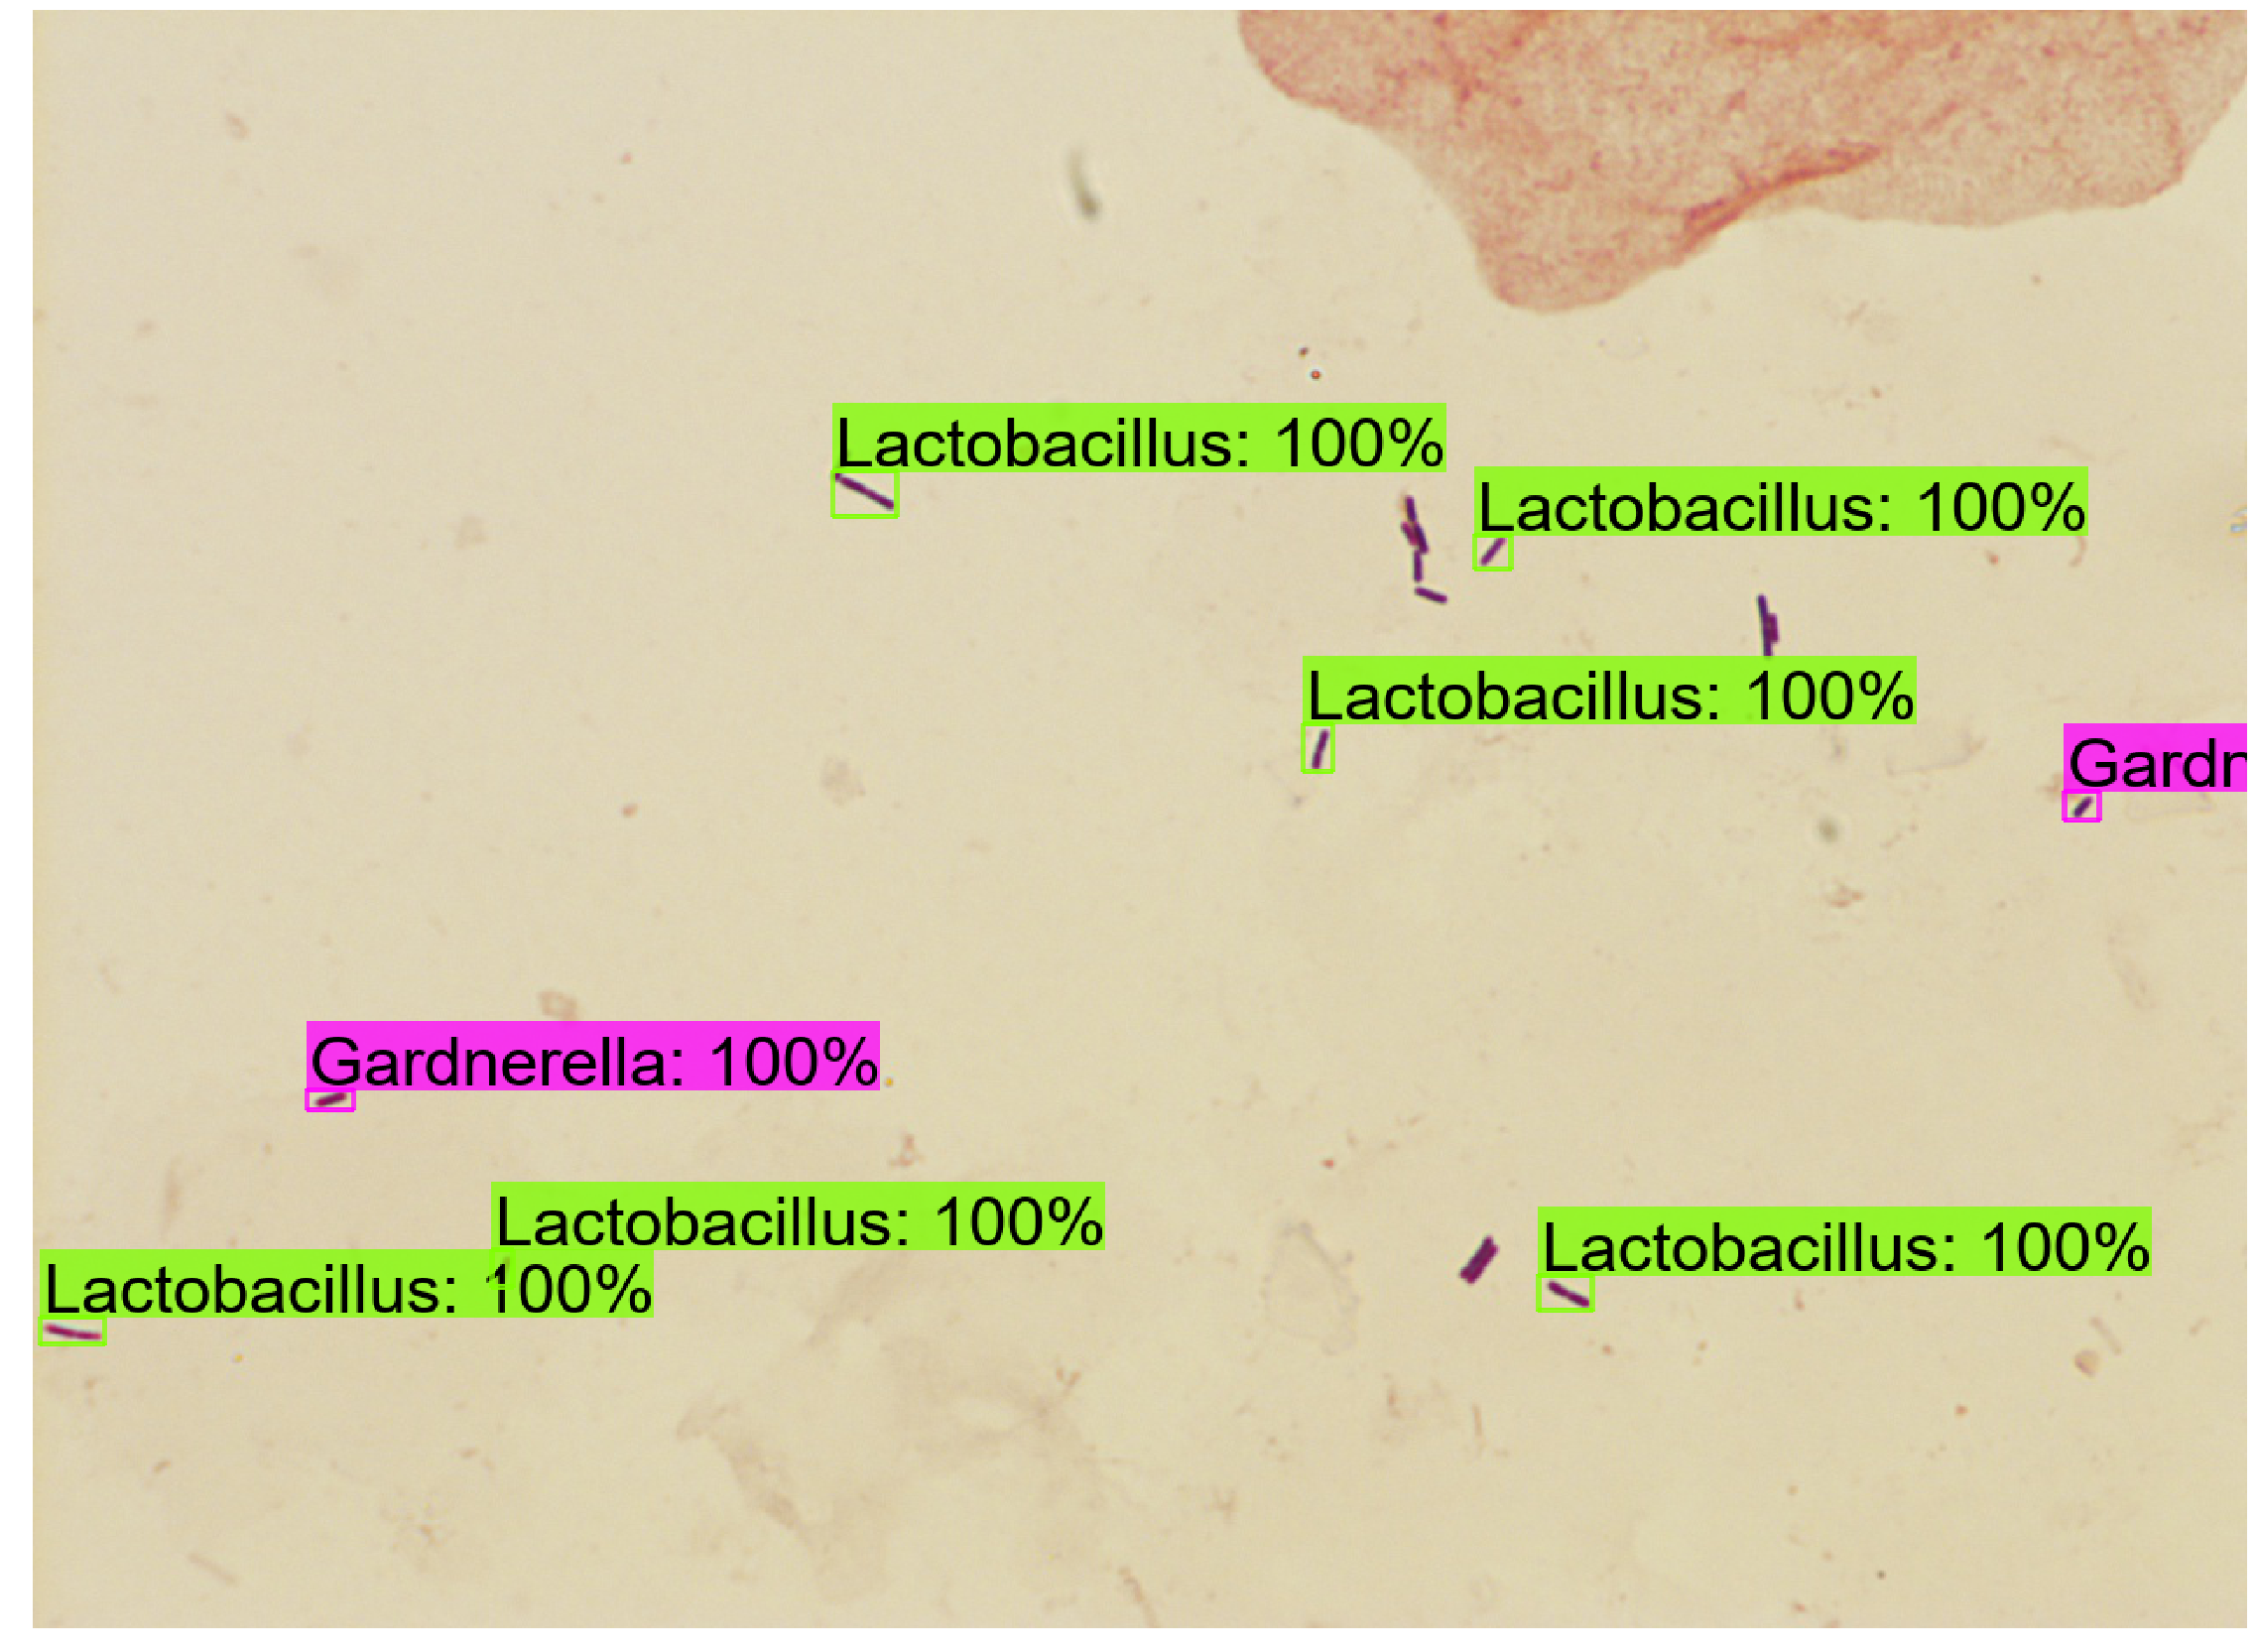

In [395]:
visualize_single_image(dataset.originals[original_file_path], img, threshold, scale=5.0/160.0, fontsize=40, line_thickness=3, alpha=192, save_to_file="foo.png")

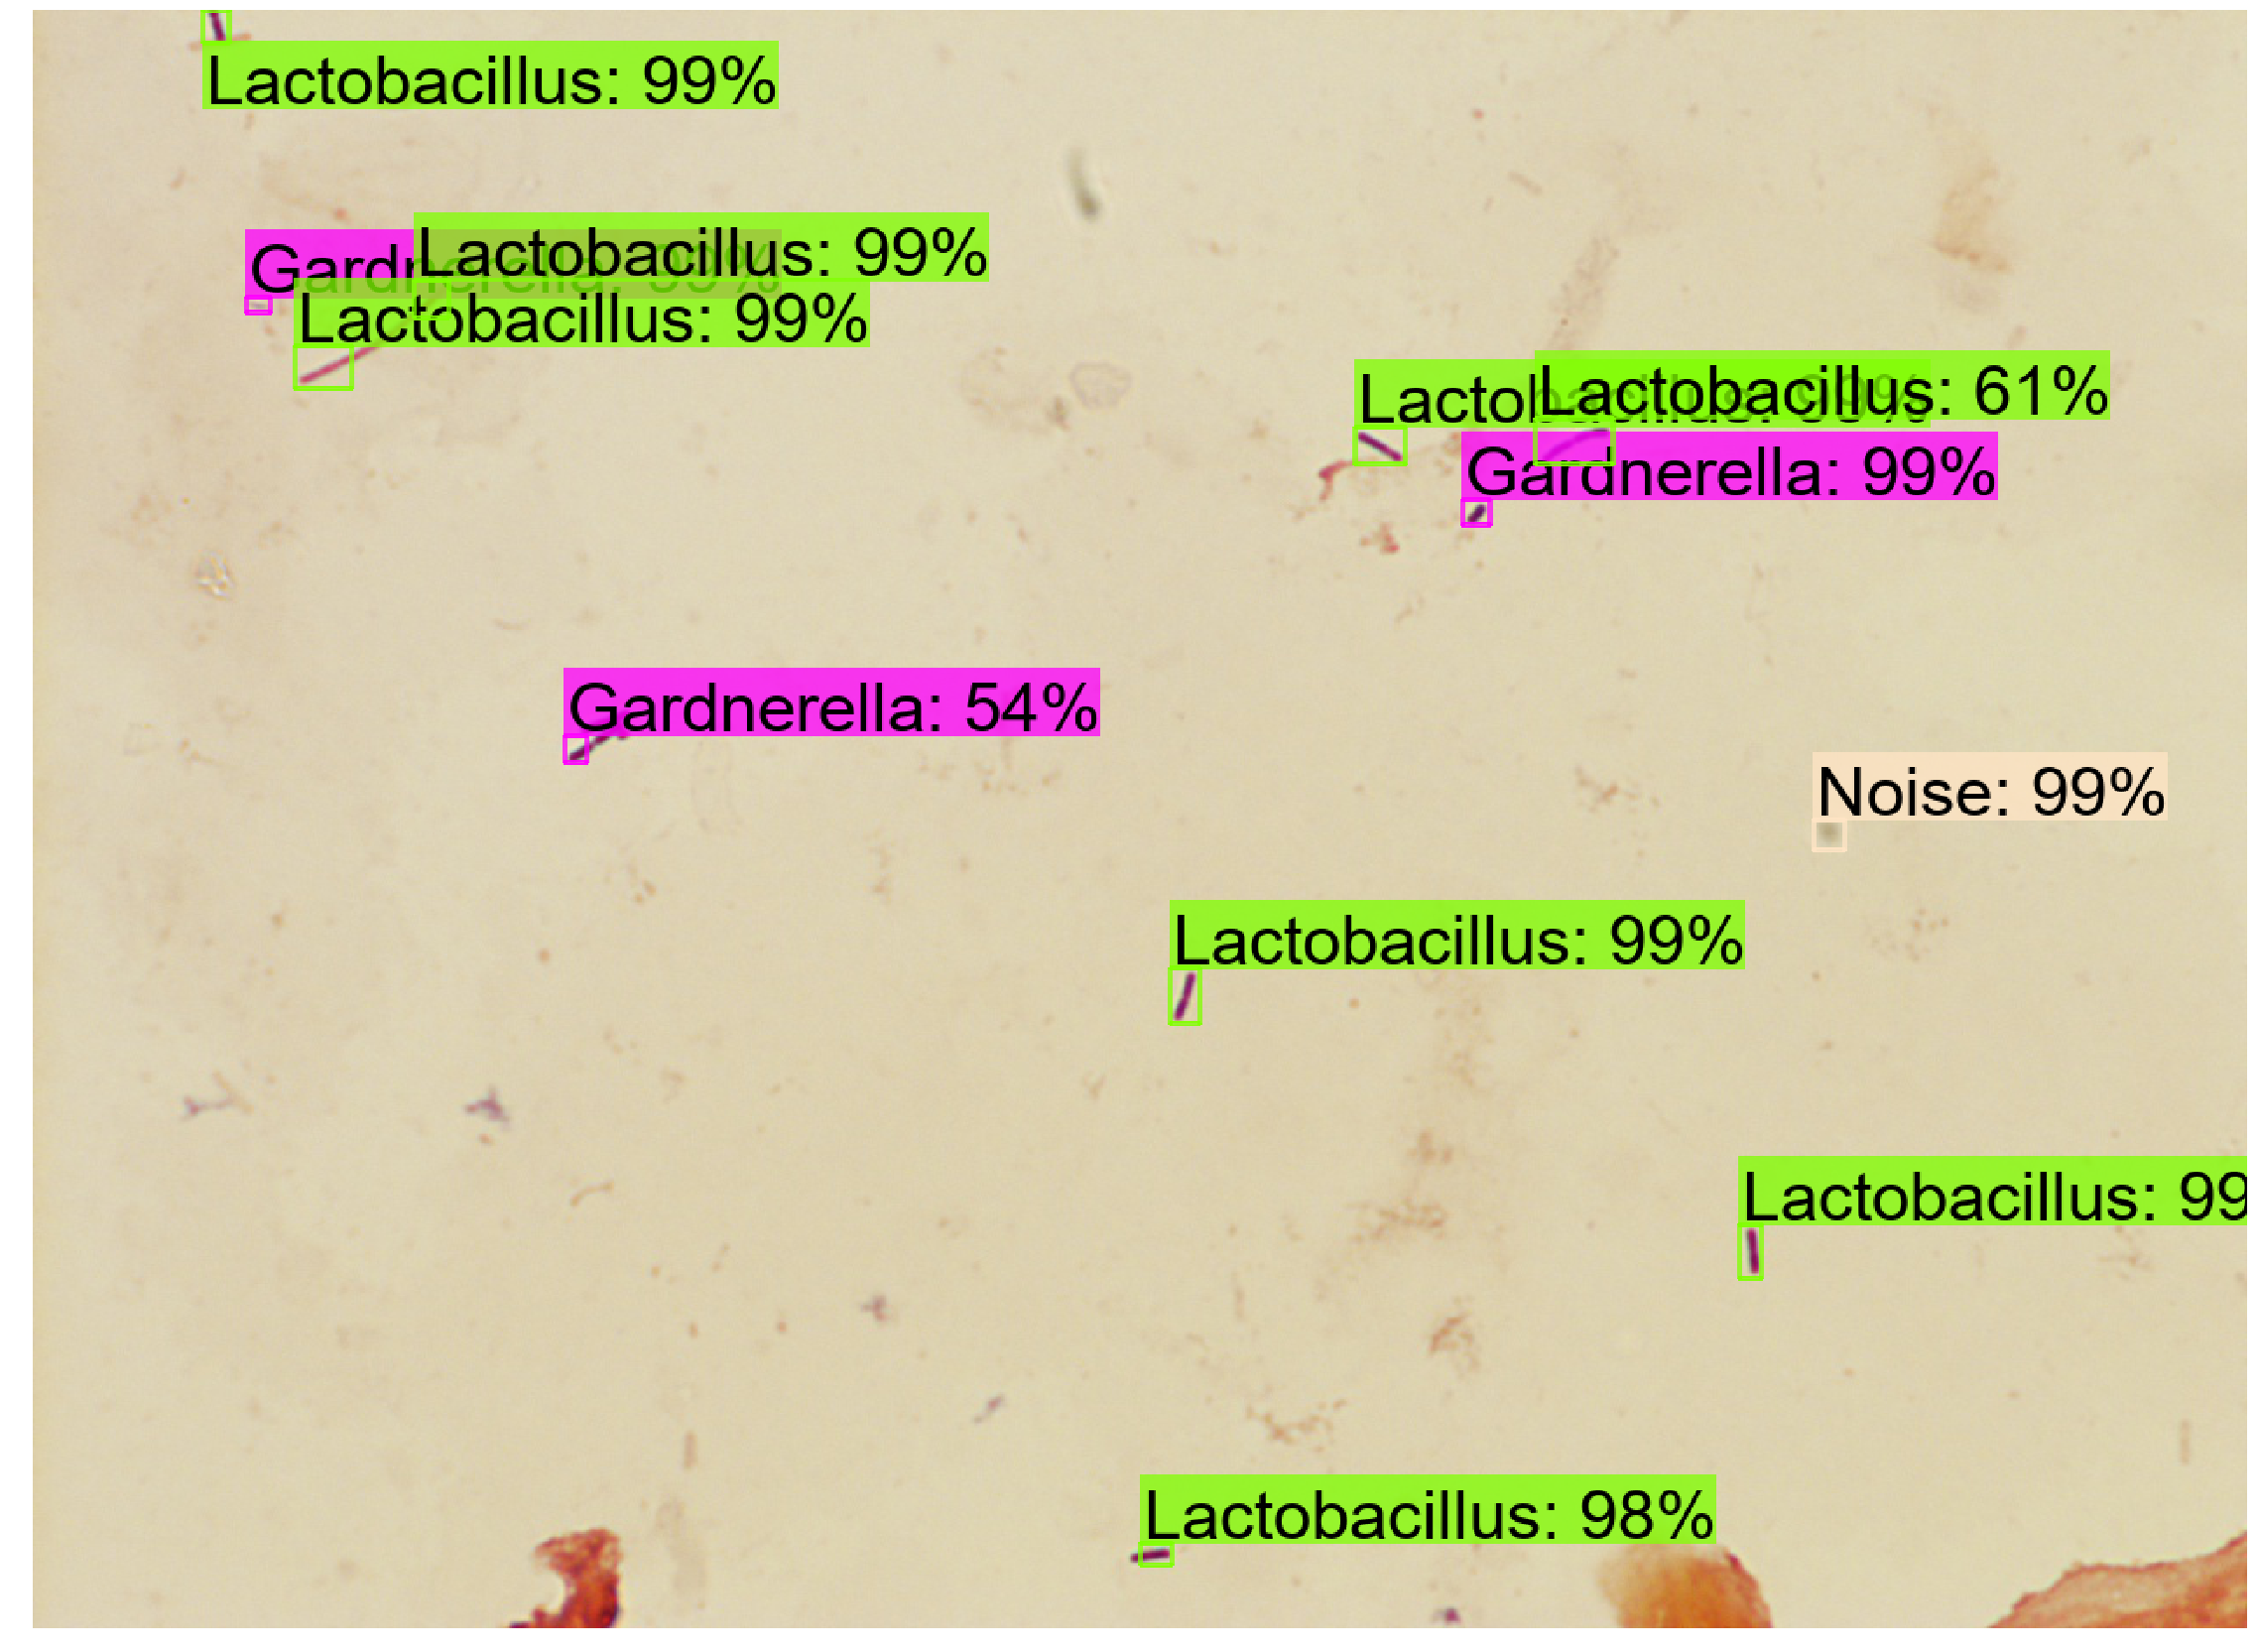

In [355]:
visualize_single_image(filtered_data, img, 0.53, scale=5.0/160.0, fontsize=40, line_thickness=3, alpha=192, save_to_file="foo1.png")

In [381]:
ground_truths = dataset.originals[original_file_path]
predictions = filtered_data
cross_table, prediction_map = accuracy_measure(predictions, ground_truths, 6, 0.8, 0.5)

In [383]:
print(cross_table)
print(prediction_map)

[[ 0  0  0  0  0  0  0  0]
 [ 0  1  1  0  0  0  0  1]
 [ 0  0 18  1  0  0  0 38]
 [ 0  1  2  0  0  0  0 14]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  2]]
[7, 7, 7, 7, 2, 2, 7, 7, 7, 7, 7, 7, 7, 7, 2, 2, 7, 7, 7, 7, 2, 7, 2, 2, 2, 7, 2, 7, 3, 1, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 2, 7, 1, 2, 7, 2, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 2, 2, 2, 2, 2, 7, 7, 2, 7, 2, 2, 7, 7, 7, 2, 7]


# All File Evaluation (and Output to database)

In [182]:
stage = 'test'

image_lists = {}
image_lists['dev'] = [7, 12, 19, 24, 39, 47, 68, 76, 86, 100, 115]
image_lists['test'] = [8, 20, 49, 67, 77, 85, 91, 117, 119]
image_lists['train'] = [i for i in range(1, 120) if i not in image_lists['dev'] and i not in image_lists['test']]

PATH_TO_LABELS = "../../../data/dataset/label_map.pbtxt"
NUM_CLASSES = 6
INTERPREATATION_PATH = "../../../data/interpretations/cleaned/original_interp.csv"

TRUTH_DATSET_PATH = "../../../data/dataset/" + stage + "_20180410.record"
PREDICTION_DATASET_PATH = "eval/" + stage + ".record"
ORIGINAL_DATASET_PATH  = "../../../data/dataset/" + stage + "_20180411_original.record"

In [183]:
dataset = Dataset(TRUTH_DATSET_PATH, PREDICTION_DATASET_PATH, ORIGINAL_DATASET_PATH, INTERPREATATION_PATH)

In [184]:
threshold = 0.1
same_class_iou = 0.01
diff_class_iou = 0.3
accuracy_iou = 0.5

label_map = {1: 0, 2: 1, 3: 2, 4: -1, 5: -1, 6: -1}
def customized_score_fn(score, label): 
    if label == 1:
        return 1 if score >= 0.8 else 0
    if label == 2:
        return 0.5 if score >= 0.8 else 0
    if label == 3:
        return 1 if score >= 0.1 else 0
    return 0

In [185]:
lacto_cross = np.zeros((5, 5), dtype=int)
gard_cross = np.zeros((5, 5), dtype=int)
curved_cross = np.zeros((3, 3), dtype=int)
score_cross = np.zeros((11, 11), dtype=int)
interp_cross = np.zeros((3, 3), dtype=int)
with h5py.File("eval/evaluation_overview.h5", "a") as f:

    for fid in image_lists[stage]:
        file_prefix = str(fid)
        
        combined_data, img, original_file_path = combine_all_segments(dataset, file_prefix)
        filtered_data = non_maximum_suppresion_apply(combined_data, threshold=threshold, same_class_iou=same_class_iou, diff_class_iou=diff_class_iou, file_info=file_prefix)
        bacteria_count, nugent_scores, interpretation = get_interpretation_overall(filtered_data, label_map, customized_score_fn)
        
        truth_nugent_scores = dataset.interpretations[original_file_path]['scores']
        print("File " + original_file_path)
        print(nugent_scores, get_nugent_score_interpretation_int(nugent_scores[0]), interpretation, bacteria_count)
        print(truth_nugent_scores, get_nugent_score_interpretation_int(truth_nugent_scores[0]), dataset.interpretations[original_file_path]['interpretation'])
        
        lacto_cross[truth_nugent_scores[1], nugent_scores[1]] += 1
        gard_cross[truth_nugent_scores[2], nugent_scores[2]] += 1
        curved_cross[truth_nugent_scores[3], nugent_scores[3]] += 1
        score_cross[truth_nugent_scores[0], nugent_scores[0]] += 1
        interp_cross[get_nugent_score_interpretation_int(truth_nugent_scores[0]), get_nugent_score_interpretation_int(nugent_scores[0])] += 1
        
        
#         visualize_single_image(filtered_data, img, threshold, scale=1.0/160.0, fontsize=20, line_thickness=3)
#         visualize_single_image(dataset.originals[original_file_path], img, threshold, scale=1.0/160.0, fontsize=20, line_thickness=3)
        
        ground_truths = dataset.originals[original_file_path]
        predictions = filtered_data
        cross_table, prediction_map = accuracy_measure(predictions, ground_truths, NUM_CLASSES, threshold, accuracy_iou)
        # print(cross_table)
        # print(prediction_map)
        
        if original_file_path in f:
            del f[original_file_path]

        now = time.localtime()
        grp = f.create_group(original_file_path)
        grp.attrs['stage'] = stage
        grp.attrs['time'] = time.strftime("%Y%m%d-%H%M%S", now)
        grp.create_dataset("pred_count", data=np.array(bacteria_count, dtype=float))
        grp.create_dataset("pred_nugent", data=np.array(nugent_scores, dtype=int)) 
        grp.create_dataset("truth_nugent", data=np.array(truth_nugent_scores, dtype=int))
        grp.create_dataset("cross_table", data=cross_table)
        grp.create_dataset("pred_map", data=np.array(prediction_map, dtype=int))
        print("-------------------------------")
        
    if stage in f:
        del f[stage]

    now = time.localtime()
    grp = f.create_group(stage)
    grp.attrs['time'] = time.strftime("%Y%m%d-%H%M%S", now)
    grp.create_dataset("lacto_cross", data=lacto_cross)
    grp.create_dataset("gard_cross", data=gard_cross) 
    grp.create_dataset("curved_cross", data=curved_cross)
    grp.create_dataset("score_cross", data=score_cross)
    grp.create_dataset("interp_cross", data=interp_cross)
    print("Evaluation Complete")

File 8.JPG
(7, 2, 4, 1) 2 Infection [3, 62.5, 5]
[10, 4, 4, 2] 2 BV
-------------------------------
File 20.JPG
(3, 1, 2, 0) 0 Normal [7, 3.5, 0]
[1, 1, 0, 0] 0 normal
-------------------------------
File 49.JPG
(6, 4, 2, 0) 1 Intermediate [0, 4.5, 0]
[9, 4, 4, 1] 2 BV
-------------------------------
File 67.JPG
(6, 2, 4, 0) 1 Intermediate [2, 74.5, 0]
[5, 1, 3, 1] 1 intermediate
-------------------------------
File 77.JPG
(7, 4, 3, 0) 2 Infection [0, 26.5, 0]
[9, 4, 4, 1] 2 BV
-------------------------------
File 85.JPG
(6, 3, 3, 0) 1 Intermediate [1, 21.5, 0]
[6, 3, 3, 0] 1 intermediate
-------------------------------
File 91.JPG
(5, 2, 3, 0) 1 Intermediate [3, 20.5, 0]
[5, 3, 2, 0] 1 intermediate
-------------------------------
File 117.JPG
(6, 2, 3, 1) 1 Intermediate [2, 13.5, 3]
[6, 3, 3, 0] 1 intermediate
-------------------------------
File 119.JPG
(6, 2, 3, 1) 1 Intermediate [3, 17.5, 2]
[7, 2, 4, 1] 2 BV
-------------------------------
Evaluation Complete


In [186]:
print(score_cross)
print(interp_cross)
print(lacto_cross) 
print(gard_cross)
print(curved_cross)

[[0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 0 0 0 0]
 [0 0 0 0 0 0 2 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0]]
[[1 0 0]
 [0 4 0]
 [0 2 2]]
[[0 0 0 0 0]
 [0 1 1 0 0]
 [0 0 1 0 0]
 [0 0 2 1 0]
 [0 0 1 0 2]]
[[0 0 1 0 0]
 [0 0 0 0 0]
 [0 0 0 1 0]
 [0 0 0 2 1]
 [0 0 1 2 1]]
[[3 1 0]
 [3 1 0]
 [0 1 0]]


In [201]:
with h5py.File("eval/evaluation_overview.h5", "r") as f:
    interp_cross = np.zeros((3, 3), dtype=int)
    score_cross = np.zeros((11, 11), dtype=int)
    for stage in ['train', 'dev', 'test']:
        interp_cross += np.array(f[stage]['interp_cross'])
        score_cross += np.array(f[stage]['score_cross'])
    print(interp_cross)
    print(score_cross)
    print(sum_diagonal_strip(score_cross, 7))

[[15  9  0]
 [ 0 31  7]
 [ 0 18 39]]
[[ 0  0  1  1  0  0  0  0  0  0  0]
 [ 0  0  1 11  8  1  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  2  4  8  1  0  0  0]
 [ 0  0  0  0  1  3  4  2  0  0  0]
 [ 0  0  0  0  1  2  6  3  1  0  0]
 [ 0  0  0  0  0  2  5  4  6  0  0]
 [ 0  0  0  0  0  0  7  6  3  0  0]
 [ 0  0  0  0  0  0  4 11  6  1  0]
 [ 0  0  0  0  0  0  0  2  0  0  0]]
[19, 58, 102, 118, 119, 119, 119, 119]


In [196]:
def sum_diagonal_strip(arr, d):
    record = []
    diag = 0
    for i in range(d + 1):
        diag += np.trace(arr, i)
        if not i == 0:
            diag += np.trace(arr, -i)
        record.append(diag)
    return record

In [216]:
target_stage = ['dev']
with h5py.File("eval/evaluation_overview.h5", "r") as f:
    count_cross_table = np.zeros((NUM_CLASSES + 1, NUM_CLASSES + 2), dtype=int)
    for k in f.keys():
        if 'stage' in f[k].attrs and f[k].attrs['stage'] in target_stage:
#             print(f[k]['cross_table'])
            count_cross_table += f[k]['cross_table']
            


[[  0   0   0   0   0   0   0   0]
 [  0  15  21   0   0   0   0  12]
 [  0   1  82   1   0   0   1 123]
 [  0   3   3   0   0   0   4  24]
 [  0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0  14]]


In [224]:
for i in range(len(score_cross)):
    for j in range(len(score_cross[0])):
        print(str(score_cross[i, j]) + '\t', end='')
    print('')

0	0	1	1	0	0	0	0	0	0	0	
0	0	1	11	8	1	0	0	0	0	0	
0	0	0	1	0	0	0	0	0	0	0	
0	0	0	0	0	0	0	0	0	0	0	
0	0	0	0	2	4	8	1	0	0	0	
0	0	0	0	1	3	4	2	0	0	0	
0	0	0	0	1	2	6	3	1	0	0	
0	0	0	0	0	2	5	4	6	0	0	
0	0	0	0	0	0	7	6	3	0	0	
0	0	0	0	0	0	4	11	6	1	0	
0	0	0	0	0	0	0	2	0	0	0	


In [146]:
with h5py.File("eval/evaluation_overview.h5", "a") as f:
    print(list(f.keys()))

['100.JPG', '115.JPG', '117.JPG', '119.JPG', '12.JPG', '19.JPG', '20.JPG', '24.JPG', '39.JPG', '47.JPG', '49.JPG', '67.JPG', '68.JPG', '7.JPG', '76.JPG', '77.JPG', '8.JPG', '85.JPG', '86.JPG', '91.JPG', 'dev', 'test']


In [ ]:
visualize_single_image(filtered_data, img, 0.8, scale=2.0/160.0, fontsize=20, line_thickness=3)

In [ ]:
image_names = ["7_0000_0000.JPG", "7_0000_0080.JPG", "7_0000_0160.JPG"]
full_visualization = True
start_eval = 150
max_eval = 30

In [143]:
FONTSIZE=12
threshold = 0.05

In [ ]:
if full_visualization:
    image_names = dataset.truths

In [183]:
_, image_names =dataset.get_all_file_names_with_prefix("7")

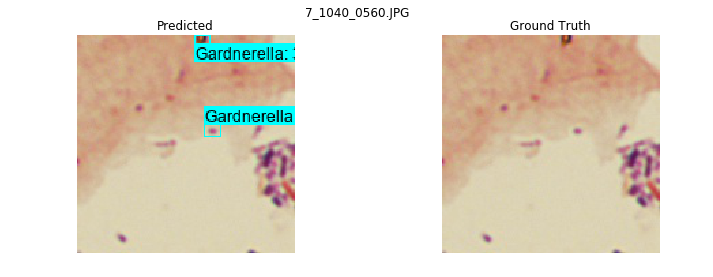

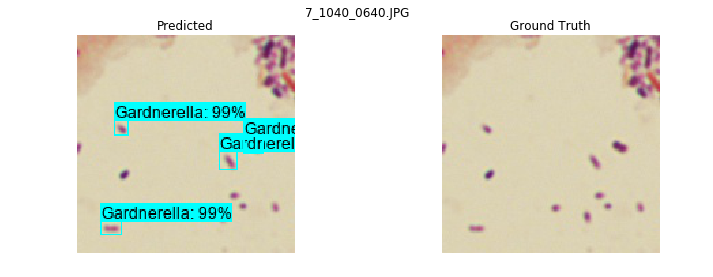

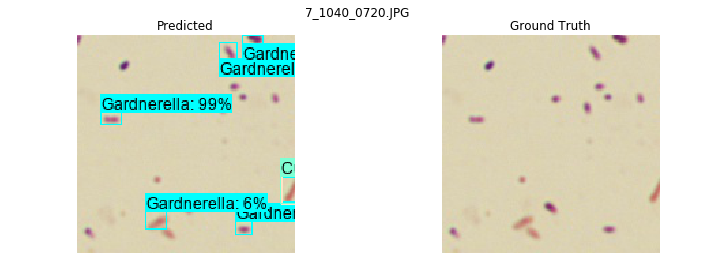

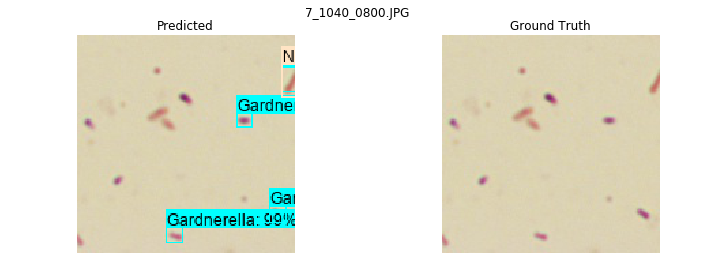

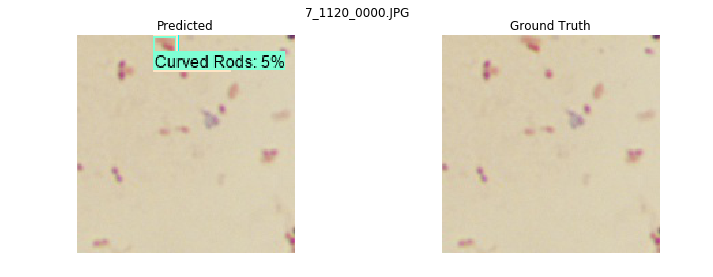

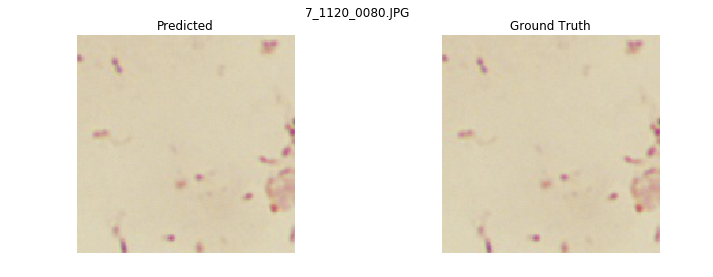

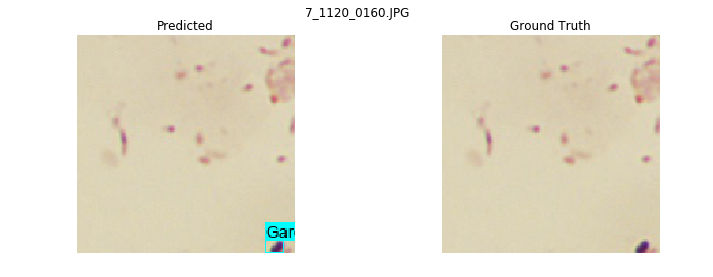

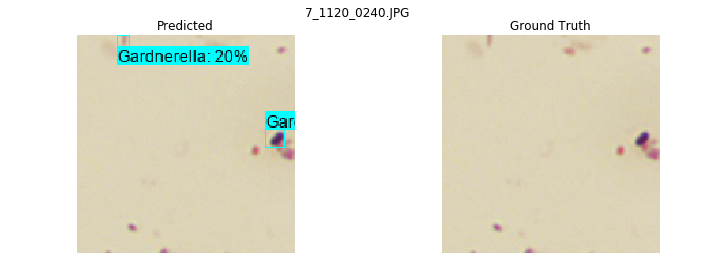

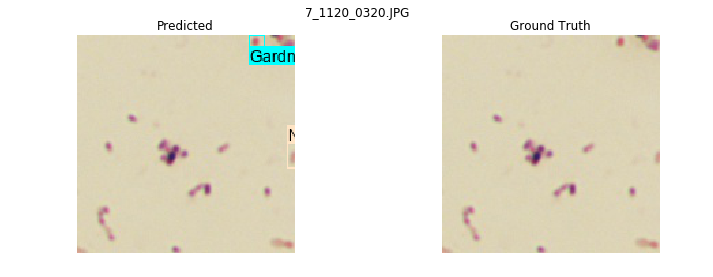

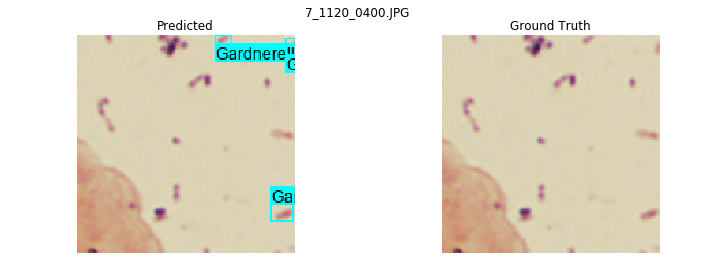

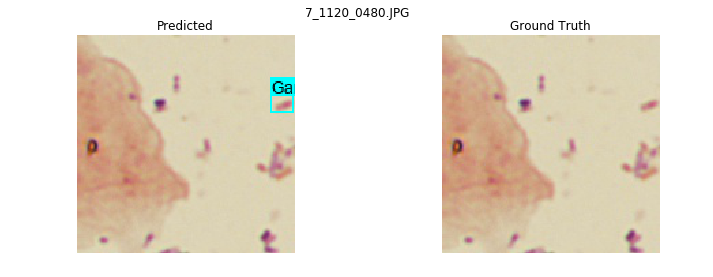

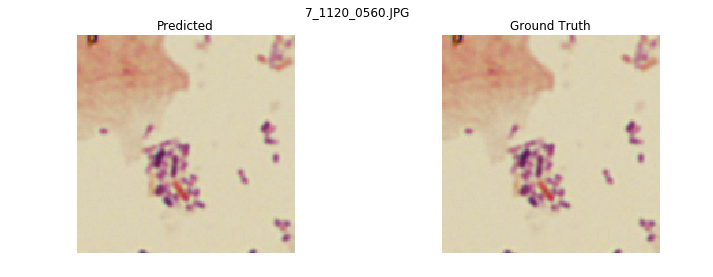

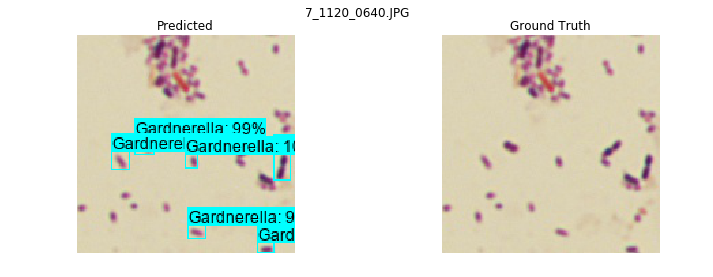

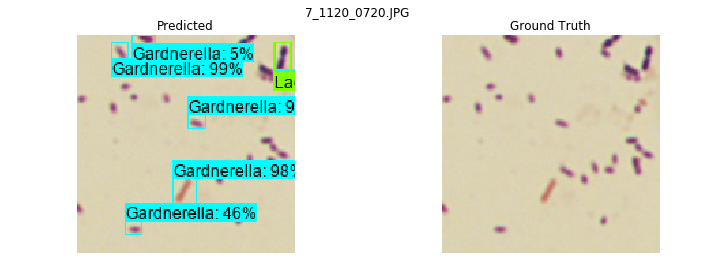

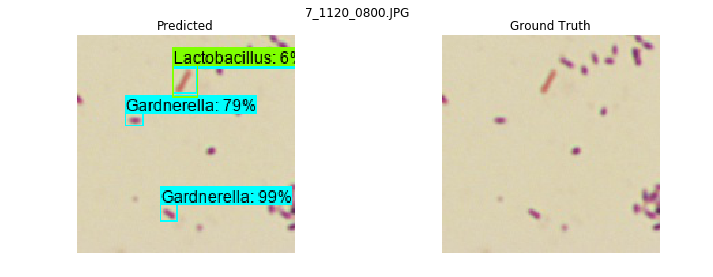

5.172911882400513


In [184]:


start = time.time()
eval_count = 0
for img_name in sorted(image_names):
    if eval_count >= start_eval:
#         img_data =  dataset.get_segment_data_by_file_name(img_name)
        truth, pred = dataset.get_segment_data_by_file_name(img_name)
        img_np = load_image_into_numpy_array(io.BytesIO(truth['encoded_jpg']))

        img_pred = vis.draw_visulizations_on_image(img_np, pred['bbox'], pred['class_label'], pred['scores'], threshold, fontsize=FONTSIZE)
        img_truth = vis.draw_visulizations_on_image(img_np, truth['bbox'], truth['class_label'], np.full(truth['label_num'], 1.0), fontsize=FONTSIZE)
        draw_comparison_images(img_pred, img_truth, img_name)
    eval_count += 1
    if full_visualization and eval_count is not None and eval_count >= max_eval + start_eval:
        break
done = time.time()
print(done - start)

In [210]:
interp_count = defaultdict(int)
score_count = defaultdict(int)

for f, v in dataset.interpretations.items():
    score_count[v['scores'][0]] += 1
    interp_count[v['interpretation']] += 1
print(interp_count)
print(sorted(list(score_count.items())))

defaultdict(<class 'int'>, {'intermediate': 38, 'normal': 24, 'BV': 57})
[(0, 2), (1, 21), (2, 1), (4, 15), (5, 10), (6, 13), (7, 17), (8, 16), (9, 22), (10, 2)]
